In [1]:
rm(list=ls())
gc()
setwd("/hpc/group/pbenfeylab/CheWei/")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,624145,33.4,1358941,72.6,1135701,60.7
Vcells,1157032,8.9,8388608,64.0,1802279,13.8


In [2]:
as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
options(future.globals.maxSize = 600000 * 1024^2)

[1] 364105268

In [3]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(circlize))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”


In [4]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Stream 8

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/ch416/miniconda3/envs/seu4/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8           LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] circlize_0.4.15       ComplexHeatmap_2.14.0 dplyr_1.1.1          
[4] ggplot2_3.4.2         SeuratObject_4.1.3    Seurat_4.1.1.9001    

loaded via a namespace (and not attached):
  [1] Rtsne_0.16             colorspace_2.1-0       rjson_0.2.21          
  [4] deldir_1.0-6   

In [5]:
cc.genes.goldy <- read.csv("./tricycle/Goldy_2021_CycB1-1-sorted_Enriched_Depleted_G2M_rm-proto-genes.csv")
cc.genes.zhang <- read.csv("./tricycle/Zhang_2021_Dev_cell_Core_cell_cycle_genes.csv")
cc.genes.amigo.go <- as.character(read.table("./tricycle/GO_cell_cycle_annotation_arabidopsis.txt", header=F)$V1)
cc.genes.f <- unique(c(cc.genes.zhang$Gene, cc.genes.goldy$gene, cc.genes.amigo.go))
length(cc.genes.f)
pp.genes <- as.character(read.table("./CW_data/escoring/Root_sc/Protoplasting_DEgene_FC2_list.txt", header=F)$V1)

[1] 3241

In [11]:
cc.genes.f <- cc.genes.f[-match(intersect(cc.genes.f,pp.genes),cc.genes.f)]

In [12]:
length(intersect(cc.genes.f,pp.genes))

[1] 0

In [13]:
length(cc.genes.f)

[1] 3170

In [6]:
use.sample <- c('dc1','dc2','sc_10_at','sc_11','sc_12','tnw1','sc_20','sc_71','sc_157','sc_158','sc_159','sc_169','sc_170','sc_171','sc_215','sc_221','sc_229','sc_235')

In [16]:
zscore <- function(x){(x-mean(x))/sd(x)}

read_seu <- function(dir,sample.name) { 
  seu <- readRDS(dir) 
  seu@assays$spliced_RNA <- NULL
  seu@assays$spliced_SCT <- NULL
  seu@assays$unspliced_RNA <- NULL
  seu@assays$unspliced_SCT <- NULL
  return(seu)
}

list.filenames <- list.files(path = "./scRNA-seq/Seurat_Objects/",pattern=".rds$") %>% .[match(use.sample, gsub("_COPILOT_seu4.rds","",.))]

rc.list <- list()
de.list <- list()
en.list <- list()
msc.list <- list()
msc2.list <- list()


for (i in 1:length(list.filenames))
{
  rc.list[[i]]<-read_seu(dir = paste0("./scRNA-seq/Seurat_Objects/",list.filenames[i]), sample.name = use.sample[i])
    rc.list[[i]]$time.anno.Li <- gsub("_.*$","",rc.list[[i]]$time.celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^.*_","",rc.list[[i]]$time.celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Distal ","",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Proximal ","",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Metaxylem","Xylem",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Protoxylem","Xylem",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Protophloem","Phloem",rc.list[[i]]$celltype.anno.Li)
    rc.list[[i]]$celltype.anno.Li <- gsub("^Metaphloem & Companion Cell","Phloem",rc.list[[i]]$celltype.anno.Li)
    #rc.list[[i]] <- subset(rc.list[[i]], cells=colnames(rc.list[[i]])[which(rc.list[[i]]$time.anno.Li=="Proliferation Domain")]) 
    
    # Set the identity of interest to cell type
    Idents(rc.list[[i]]) <- "celltype.anno.Li"
    # Use SCT assay 
    DefaultAssay(rc.list[[i]]) <- "SCT"
    de.list[[i]] <- FindAllMarkers(rc.list[[i]],
                                max.cells.per.ident = 10000,
                                only.pos=T, 
                               test.use="wilcox")
    de.list[[i]] <- de.list[[i]] %>% filter(p_val_adj < 0.01 & avg_log2FC > 0.25)
    
    msc <- c()
    suppressWarnings(
    for (j in as.character(intersect(cc.genes.f,rownames(rc.list[[i]])))){
        msc <- cbind(msc, as.numeric(zscore(as.matrix(rc.list[[i]]@assays$SCT@data)[which(rownames(rc.list[[i]])==j),])))
    }
    )
    colnames(msc) <- intersect(cc.genes.f,rownames(rc.list[[i]]))
    rownames(msc) <- colnames(rc.list[[i]])
    msc.list[[i]] <- msc
    
    msc2 <- c()
    for (k in c("Proliferation Domain", "Transition Domain", "Proximal Columella", "Proximal Lateral Root Cap", "Elongation", "Maturation", "Distal Columella", "Distal Lateral Root Cap")){
        msc2 <- cbind(msc2,apply(msc[which(rc.list[[i]]$time.anno.Li==k),],2,mean))
    }
    colnames(msc2) <- c("Proliferation Domain", "Transition Domain", "Proximal Columella", "Proximal Lateral Root Cap", "Elongation", "Maturation", "Distal Columella", "Distal Lateral Root Cap")
    msc2.list[[i]] <- msc2
    
    en.list[[i]] <- names(which(apply(msc2, 1, which.max)==5 | apply(msc2, 1, which.max)==6 |apply(msc2, 1, which.max)==7 | apply(msc2, 1, which.max)==8))
    
}

names(rc.list) <- list.filenames %>% gsub("./scRNA-seq/Seurat_Objects/","",.)

#for (i in 1:length(list.filenames))
#{
#  rc.list[[i]]<- suppressWarnings(suppressMessages(UpdateSeuratObject(rc.list[[i]])))
#}

#for (i in 1:length(list.filenames))
#{
#  rc.list[[i]] <-  FindVariableFeatures(rc.list[[i]], selection.method = "vst", nfeatures = 2000)
#}

Calculating cluster Atrichoblast

Calculating cluster Lateral Root Cap

Calculating cluster Endodermis

Calculating cluster Trichoblast

Calculating cluster Cortex

Calculating cluster Xylem

Calculating cluster Xylem Pole Pericycle

Calculating cluster Columella

Calculating cluster Phloem

Calculating cluster Procambium

Calculating cluster Quiescent Center

Calculating cluster Phloem Pole Pericycle

Calculating cluster Lateral Root Cap

Calculating cluster Cortex

Calculating cluster Phloem Pole Pericycle

Calculating cluster Atrichoblast

Calculating cluster Procambium

Calculating cluster Trichoblast

Calculating cluster Columella

Calculating cluster Phloem

Calculating cluster Endodermis

Calculating cluster Quiescent Center

Calculating cluster Xylem Pole Pericycle

Calculating cluster Xylem

Calculating cluster Lateral Root Cap

Calculating cluster Procambium

Calculating cluster Endodermis

Calculating cluster Trichoblast

Calculating cluster Xylem Pole Pericycle

Calculating

In [17]:
rc.list

$dc1_COPILOT_seu4.rds
An object of class Seurat 
47748 features across 3378 samples within 2 assays 
Active assay: SCT (21818 features, 21818 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$dc2_COPILOT_seu4.rds
An object of class Seurat 
47752 features across 3283 samples within 2 assays 
Active assay: SCT (22007 features, 22007 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$sc_10_at_COPILOT_seu4.rds
An object of class Seurat 
48681 features across 9286 samples within 2 assays 
Active assay: SCT (22780 features, 22780 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$sc_11_COPILOT_seu4.rds
An object of class Seurat 
47690 features across 9177 samples within 2 assays 
Active assay: SCT (22354 features, 22354 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$sc_12_COPILOT_seu4.rds
An object of clas

In [18]:
de.list

In [35]:
save(de.list, en.list, msc.list, msc2.list, file="./scRNA-seq/Integrated_Objects/Lists_18S_WT_cell_cycle_seu4_245genes_Goldy_Zhang_AMIGO_20230825.RData")

In [20]:
de <- c()
for (i in 1:length(list.filenames)){
de <- unique(c(de,de.list[[i]]$gene))
}
de <- unique(c(de, pp.genes))

In [21]:
length(de)

[1] 14625

In [27]:
rc.features <- SelectIntegrationFeatures(object.list = rc.list, nfeatures = 25000)
length(rc.features)

[1] 19907

In [28]:
## Remove Cell type specific DE genes
rc.features <- rc.features[-c(sort(match(de, rc.features)))]
#rc.features <- rc.features[-c(grep("ATMG",rc.features),grep("ATCG",rc.features),sort(match(pp.genes, rc.features)))]
length(rc.features)

[1] 6048

In [29]:
rc.features <- rc.features[sort(match(cc.genes.f, rc.features))]
#rc.features <- rc.features[-c(grep("ATMG",rc.features),grep("ATCG",rc.features),sort(match(pp.genes, rc.features)))]
length(rc.features)

[1] 679

In [32]:
## Remove elongation, maturation, distal root cap enriched genes
#en <- names(which(rev(sort(table(unlist(en.list))))>length(use.sample)/2))
## Remove Cell type specific elongation/maturation/distal enriched genes in any sample
en <- names(which(rev(sort(table(unlist(en.list))))>0))
rc.features <- rc.features[-c(sort(match(en, rc.features)))]
length(rc.features)

[1] 245

In [33]:
rc.list <- PrepSCTIntegration(object.list = rc.list, anchor.features = rc.features, verbose = TRUE)

In [ ]:
# No reference
rc.anchors <- suppressMessages(FindIntegrationAnchors(object.list = rc.list, normalization.method = "SCT", 
    anchor.features = rc.features, verbose = TRUE))

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [38]:
rc.integrated <- suppressMessages(IntegrateData(anchorset = rc.anchors, normalization.method = "SCT", verbose = TRUE))

Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”
Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”


In [39]:
rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)

In [40]:
#rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, metric = "correlation", n.components = 3)
#rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation", n.components = 3)
#rc.integrated@reductions$umap_3D <- rc.integrated@reductions$umap
rc.integrated <- suppressMessages(RunUMAP(rc.integrated, reduction = "pca", dims = 1:4))
#rc.integrated <- RunUMAP(rc.integrated, reduction = "pca", dims = 1:50, umap.method = "umap-learn", metric = "correlation")
rc.integrated@reductions$umap_2D <- rc.integrated@reductions$umap
rc.integrated <- suppressMessages(FindNeighbors(rc.integrated, reduction = "pca",dims = 1:50))
rc.integrated <- suppressMessages(FindClusters(rc.integrated, resolution = 0.5, algorithm = 3))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 199810
Number of edges: 9712934

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.9587
Number of communities: 529
Elapsed time: 257 seconds


In [41]:
saveRDS(rc.integrated, file = "./scRNA-seq/Integrated_Objects/rc.integrated_18S_WT_cell_cycle_seu4_245genes_Goldy_Zhang_AMIGO_20230825.rds")

In [7]:
rc.integrated <- readRDS("./scRNA-seq/Integrated_Objects/rc.integrated_18S_WT_cell_cycle_seu4_245genes_Goldy_Zhang_AMIGO_20230825.rds")

In [42]:
length(rownames(rc.integrated))

[1] 245

## UMAP

In [45]:
rc.integrated <- suppressMessages(RunUMAP(rc.integrated, reduction = "pca", dims = 1:3))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



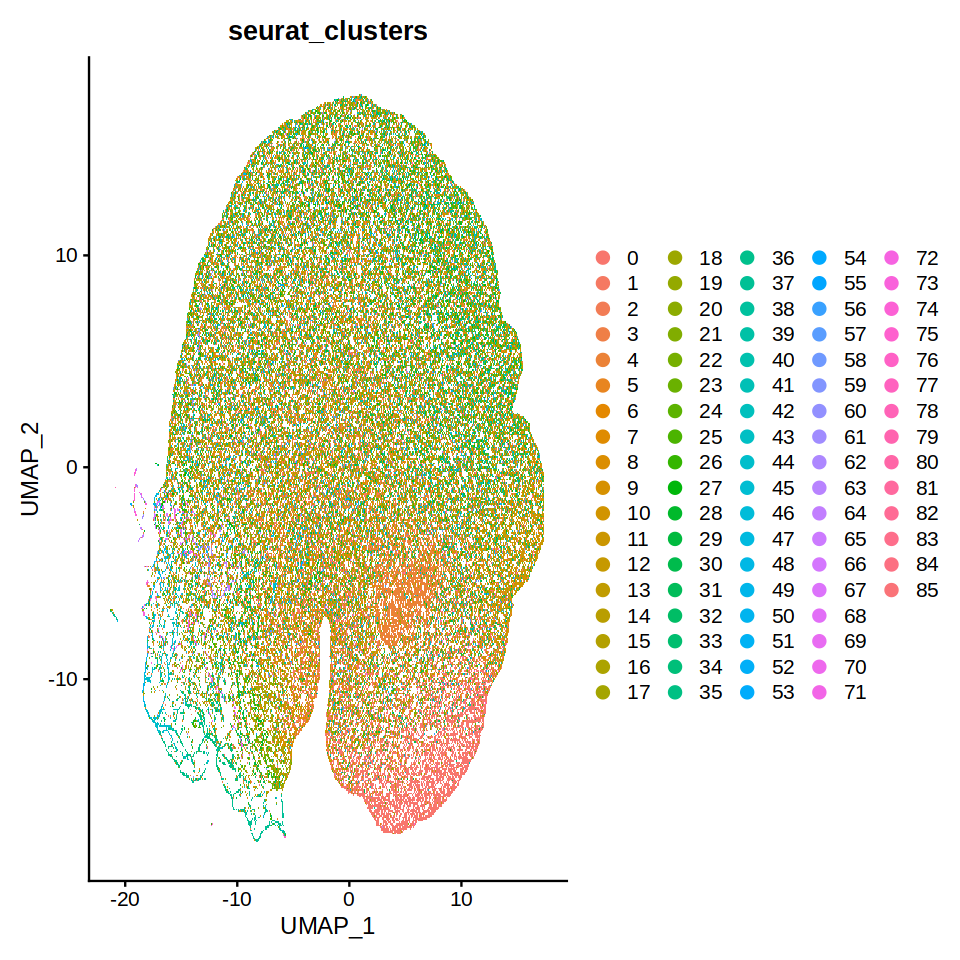

In [46]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "seurat_clusters", label = FALSE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



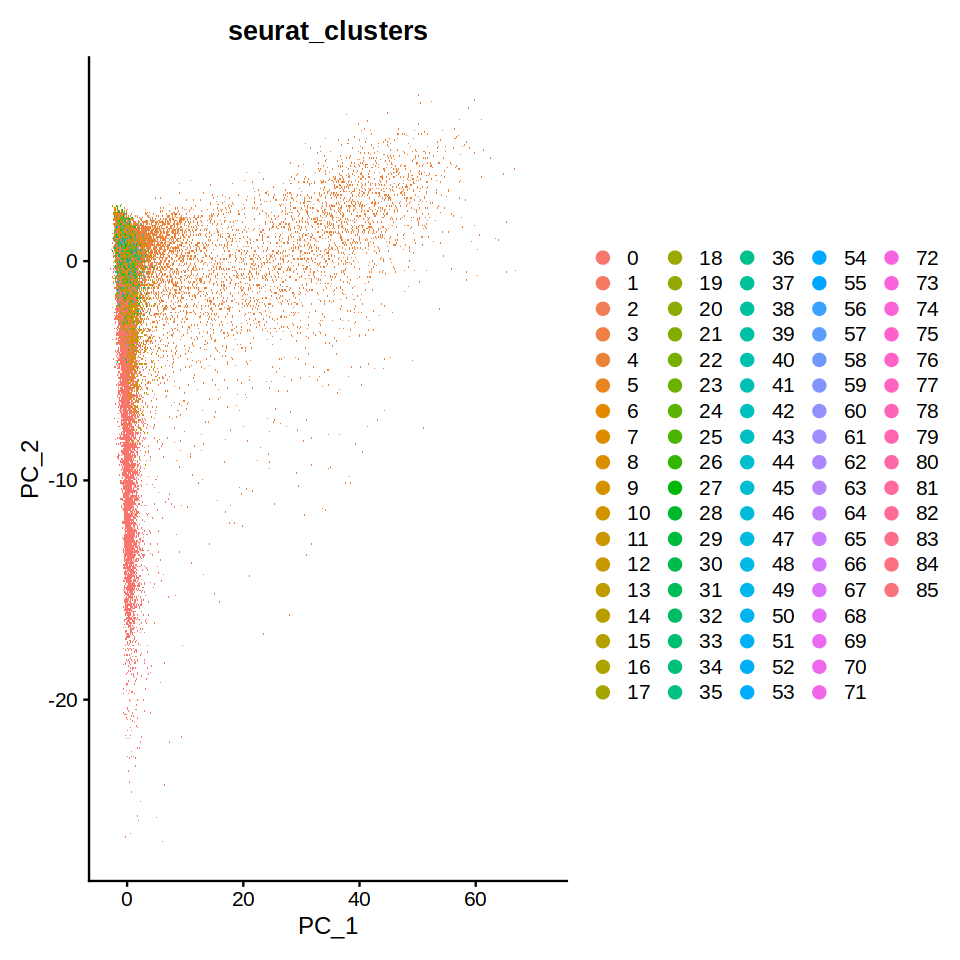

In [44]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "pca", group.by = "seurat_clusters", label = FALSE)